 GAN Assisted Open Loop (GAOL) analysis workbook - Code used for experiments detailed in UAI 2022 Paper:
 
 Enhanced Adaptive Optics Control with Image to Image Translation.
 
 Written by Jesse Craney and Jeffrey Smith
 
 This code requires a system already configured with the COMPASS AO simulation software 
 --> see the COMPASS home for information (and install instructions)
 https://anr-compass.github.io/compass-new/

In [1]:
# initialise everything
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy
import numpy as np
from copy import deepcopy

# import supervisor
from shesha import config as conf
from shesha.supervisor.compassSupervisor import CompassSupervisor as Supervisor
from shesha.config import ParamConfig

from options.test_options import TestOptions
from models import create_model
import copy
import torch


#param_file = "scao.py"
param_file = "./COMPASS_PARAM/r0_batch/r0_093_W10_p512_s9999.py"
config = ParamConfig(param_file)
print(config.p_wfss[0].get_nxsub())

config.p_controllers[0].set_type("generic_linear")
config.p_controllers[0].set_n_iir_in(1)
config.p_controllers[0].set_n_iir_out(1)
config.p_controllers[0].set_polc(True)
config.p_controllers[0].set_ndm([0,2])

config.p_controllers.append(conf.Param_controller())
ctrl_new = config.p_controllers[-1]
ctrl_new.set_type("generic_linear")
ctrl_new.set_ndm([1])
ctrl_new.set_nwfs([1])
ctrl_new.set_delay(1)
ctrl_new.set_n_iir_in(1)
ctrl_new.set_n_iir_out(1)

config.p_dms[0].set_nact(config.p_wfss[0].get_nxsub()+1)

config.p_dms = [config.p_dms[0],conf.Param_dm(),config.p_dms[1]]
dm_new = config.p_dms[1]
dm_old = config.p_dms[0]
dm_new.set_type("pzt")

# new dm should be able to handle a higher actuator count
#  +  |    SR
# ------------
# lin |  62.24
# ------------
#  cl |  64.32
# ------------
#  0  |  67.34
#  1  |  69.84
#  2  |  70.22
#  4  |  71.18
#  8  |  72.70 <- here seems good value/demand
#  16 |  73.13
#  32 |  72.05
 
nact_new = dm_old.get_nact()+7
dm_new.set_nact(nact_new)
dm_new.set_alt(0.)
dm_new.set_thresh(-1)
dm_new.set_coupling(0.2)
dm_new.set_unitpervolt(0.01)
dm_new.set_push4imat(100.)
dm_new.set_keep_all_actu(True)

config.p_targets[0].set_dms_seen(np.r_[0,1,2])

config.p_wfss[0].set_dms_seen(np.r_[0,2])

config.p_wfss.append(deepcopy(config.p_wfss[0]))
config.p_wfss[1].set_dms_seen(np.r_[0,1,2])

config.p_centroiders.append(deepcopy(config.p_centroiders[0]))
config.p_centroiders[-1].set_nwfs(1)

config.p_atmos.set_r0(0.10) # best to only set r0 in the config, before initialising turbulence.

# init with config
sup = Supervisor(config)
pupilMask = sup.get_s_pupil()
pup = sup.get_m_pupil()
pup_filter = (pup==1)

def pfphase(phi):
    phi[pup_filter] -= phi[pup_filter].mean()
    phi *= pup
    return phi#[2:-2, 2:-2]

def SetData(Wfs):
    uNetsize = 512
    A = copy.deepcopy(Wfs) / 1200000
    ApadVal = int(uNetsize / 2 - A.shape[0] / 2)
    A = np.pad(A, ((ApadVal, ApadVal), (ApadVal, ApadVal)), 'constant')
    A = np.expand_dims(A, axis=0)
    A = np.expand_dims(A, axis=0)
    A = torch.from_numpy(A)
    B = A
    AB_path = ''
    return {'A': A, 'B': B, 'A_paths': AB_path, 'B_paths': AB_path}

def DeGANPhase(theGANPhase):
    thePhase = copy.deepcopy(theGANPhase)
    thePhase = thePhase -0.5
    thePhase = thePhase * pupilMask
    thePhase = thePhase * 5
    return thePhase


trueDim = int(pupilMask.shape[0])

###Low Wind
#theVars = ["--dataroot", "./trainingdata/Sample_r012/", "--COMPASS_pFile", "./trainingdata/Sim_param_r0_012.py", "--load_size=512", "--netG=unet_512", "--input_nc=1", "--output_nc=1", "--dataset_mode", "npApSuPhaseRawWFS1Mpiston", "--name", "LW", "--model", "pix2pixExM"]

###High Wind
#theVars = ["--dataroot", "./trainingdata/Sample_r012/", "--COMPASS_pFile", "./trainingdata/Sim_param_r0_012.py","--load_size=512", "--netG=unet_512", "--input_nc=1", "--output_nc=1", "--dataset_mode", "npApSuPhaseRawWFS1Mpiston", "--name", "HW", "--model", "pix2pixExM"]

###DirectAmplitude network
theVars = ["--dataroot", "./trainingdata/Sample_r012/", "--epoch", "65", "--COMPASS_pFile", "./COMPASS_PARAMS/r0_batch/r0_093_W10_p512_s9999.py","--load_size=512", "--netG=unet_256", "--input_nc=1", "--output_nc=1", "--dataset_mode", "pistonDivConst10", "--name", "DirectAmplitude", "--model", "pix2pixExM"]

opt = TestOptions().parse_withVars(theVars) # get test options
model = create_model(opt)
model.setup(opt)

loading: r0_093_W10_p512_s9999
16
->telescope init
*-----------------------
Computing geometry of WFS 1
r0 for WFS : 0.10  m
seeing for WFS :  1.03Using device 0: "NVIDIA GeForce RTX 3090" with Compute 8.6 capability
 "
quantum pixsize :  0.0516 "
simulated FoV :  6.60 " x  6.60 "
actual pixsize :  0.3094
actual FoV :  2.48 " x  2.48 "
number of phase points :  32
size of fft support :  128
size of HR spot support :  128
pupdiam used:  512
Generic pupil created
nphotons :  1577393.3612004826
*-----------------------
Computing geometry of WFS 0
r0 for WFS : 0.10  m
seeing for WFS :  1.03 "
quantum pixsize :  0.0516 "
simulated FoV :  6.60 " x  6.60 "
actual pixsize :  0.3094
actual FoV :  2.48 " x  2.48 "
number of phase points :  32
size of fft support :  128
size of HR spot support :  128


  0%|                                                     | 0/1 [00:00<?, ?it/s]

nphotons :  1577393.3612004826
->atmosphere init
Creating turbulent layers :r0^-5/6 :0.0169423



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]

->dms init
DM pitch = 32.00000 pix =  0.50000 m



100%|███████████████████████████████████████| 284/284 [00:00<00:00, 1565.00it/s]


Pattern type : square
Computing Influence Function type :  default
DM pitch = 22.26087 pix =  0.34783 m


 36%|█████████████▉                         | 279/784 [00:00<00:00, 2786.00it/s]

Pattern type : square
Computing Influence Function type :  default


100%|███████████████████████████████████████| 784/784 [00:00<00:00, 2616.71it/s]
wfs uses 1 streams
wfs uses 1 streams
DM1: 100%|██████████████████████████████████████| 2/2 [00:00<00:00, 5102.56it/s]

->target init
->wfs init
Doing imat geom...
Filtering unseen actuators... 



DM0: 100%|█████████████████████████████████| 784/784 [00:00<00:00, 13156.86it/s]

Done
CONTROLLER ADDED
Doing imat geom...
Filtering unseen actuators... 


Done
CONTROLLER ADDED
Computing IF sparse...
total number of actuators 222
Autocorrelation index for CLOSE optimization is 3
the model name - pix2pixExM
----------------- Options ---------------
            COMPASS_pFile: ./COMPASS_PARAMS/r0_batch/r0_093_W10_p512_s9999.py	[default: ]
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 512                           
                 dataroot: ./trainingdata/Sample_r012/   	[default: /home/jeff/GITs/COMPASS/SH200k_r0_012_TargetPhase_Tilt_Roket/]
             dataset_mode: pistonDivConst10              	[default: aligned]
                direction: AtoB                          
          display_winsize: 512                           
                    epoch: 65                            	[default: latest]
                     eval: False                         
                  gpu_ids

## Simple Linear Integrator Control
### The interaction matrix
Start with building the *interaction matrix*, $D$, and assuming that the WFS slopes, $s$, are a linear combination of the actuator voltages, $u$. That is:
$$
s_j = \sum_{i=1}^{\mathrm{NACT}} D_{ji} u_i
$$
or simply:
$$
s = D u
$$

If the relationship is linear, then $D$ can be found by applying a unit voltage to each actuator, one at a time, and recording the slope response. This is the so-called "poke-test". The slope vector obtained after *poking* the $i^\mathrm{th}$ actuator forms the $i^\mathrm{th}$ column of the interaction matrix, $D_{:i}$

In [2]:
imat = sup.rtc.get_interaction_matrix(0)
nact = imat.shape[1]
u_onehot = np.zeros(nact)
u_onehot[0] = 1.0
D = []
print(imat.shape)
sup.dms.set_command(np.zeros(sup.config.p_dms[1].get_ntotact()),dm_index=1)
for i in range(nact):
    u_tmp = np.roll(u_onehot,i)
    sup.rtc.set_command(0,u_tmp)
    sup.rtc.apply_control(0,comp_voltage=False)
    sup.wfs.raytrace(0,dms=sup.dms)
    sup.rtc.do_centroids_geom(0)
    sup.rtc.get_slopes(0)
    s_tmp = sup.rtc.get_slopes(0)
    D.append(s_tmp)

# interaction matrix:
imat = np.c_[D].T/u_onehot[0]
print(f"{imat.shape=}")

(368, 222)
imat.shape=(368, 222)


### The command matrix

The simplest goal of an AO system is to *minimise the WFS slopes*. This is an effective proxy for the true goal of an AO system which is to *minimise the variance of the wavefront phase*.

Putting the practical goal into a mathematical formalise, we can define a cost function $J(u)$ as the 2-norm of residual slopes, after DM correction:

\begin{aligned}
J(u) & = || s_\mathrm{residual}||^2 \\
& = || s_\mathrm{atm} + s_\mathrm{dm} ||^2 \\
& = ||s_\mathrm{atm} + Du||^2 \\
& = (s_\mathrm{atm} + Du)^T(s_\mathrm{atm} + Du) \\
& = s_\mathrm{atm}^Ts_\mathrm{atm} + 2u^TD^Ts_\mathrm{atm} + u^TD^T D u \\
& = 2u^TD^Ts_\mathrm{atm} + u^TD^T D u
\end{aligned}

Which has a unique global minimum when $\nabla J = \frac{\partial J}{\partial u} = \vec{0}$ 
$$
\nabla J(u) = 2D^Ts_\mathrm{atm} + 2D^T D u = \vec{0}
$$
$$
\therefore u = -\underbrace{(D^T D)^{-1}D^T}_{\triangleq C}s_\mathrm{atm}
$$
where $C$ is the *control matrix*. This means, that given a slope vector based on the atmosphere, we can find a command vector that will minimise the total WFS slopes by:
$$
u = -Cs_\mathrm{atm}
$$

DM 0 NACT:  220
DM 1 NACT:  784
WFS 0 NSLOPE:  368
CMAT SHAPE:  (222, 368)
----------------------------------------------------
iter# | S.E. SR | L.E. SR | ETR (s) | Framerate (Hz)
----------------------------------------------------
 loop execution time: 0.1392979621887207   ( 100 iterations),  0.001392979621887207 (mean)   717.8855916393101 Hz
----------------------------------------------------
iter# | S.E. SR | L.E. SR | ETR (s) | Framerate (Hz)
----------------------------------------------------
1000 	 0.634 	  0.617	     0.0 	 854.3
 loop execution time: 1.3021750450134277   ( 1000 iterations),  0.0013021750450134277 (mean)   767.9459100598017 Hz


<IPython.core.display.Javascript object>


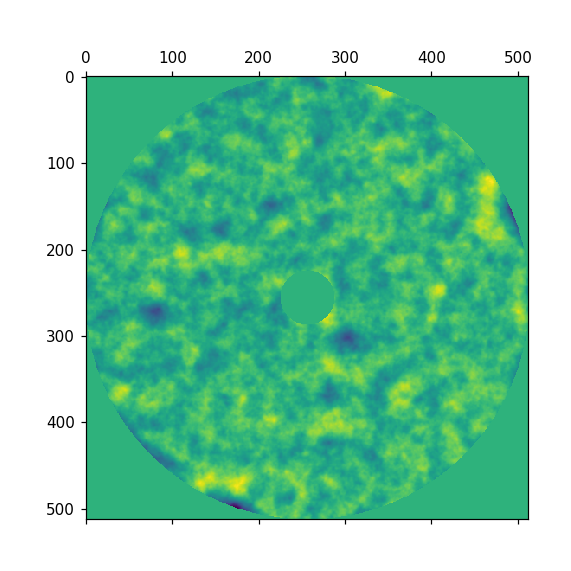

In [3]:
#reg = 5e-6

#imatTimat = imat.T @ imat + np.eye(imat.shape[1])*reg
#print(f"{np.linalg.cond(imatTimat)=}")

gain = 0.7
U,D,V=np.linalg.svd(imat,full_matrices=False)
nmodefilt = 7
cmat = V.T[:,:-nmodefilt] @ np.diag(1/D[:-nmodefilt]) @ U.T[:-nmodefilt,:]

"""
u_filt = V[-nmodefilt:,:]
print(u_filt.shape)
for u_filt_i in u_filt:
    sup.dms.set_command(u_filt_i)
    sup.wfs.raytrace(0,dms=sup.dms)
    plt.matshow(sup.wfs.get_wfs_phase(0)*sup.get_m_pupil())
"""

sup.rtc.set_D_matrix(0,imat)
sup.rtc.set_L_matrix(0,0,-cmat)
sup.rtc.set_iir_a_vector(0,0,(1-gain)*np.ones(imat.shape[1]))
sup.rtc.set_iir_b_vector(0,0,(gain)*np.ones(imat.shape[1]))

print("DM 0 NACT: ",sup.config.p_dms[0].get_ntotact())
print("DM 1 NACT: ",sup.config.p_dms[1].get_ntotact())
print("WFS 0 NSLOPE: ",sup.config.p_wfss[0].get_nvalid()*2)
print("CMAT SHAPE: ", cmat.shape)

sup.reset()
sup.rtc.set_iir_a_vector(0,0,np.zeros(imat.shape[1]))
sup.rtc.set_iir_b_vector(0,0,np.zeros(imat.shape[1]))
sup.loop(100,monitoring_freq=1000)
sup.reset()
sup.rtc.set_iir_a_vector(0,0,(1-gain)*np.ones(imat.shape[1]))
sup.rtc.set_iir_b_vector(0,0,(gain)*np.ones(imat.shape[1]))
sup.loop(1000,monitoring_freq=1000)

x = sup.target.get_tar_phase(0,pupil=True)
x[x!=0]-=x[x!=0].mean()
plt.matshow(x)

### COMPASS API
COMPASS has a convenient API that implements all of the above in a GPU optimised loop.

----------------------------------------------------
iter# | S.E. SR | L.E. SR | ETR (s) | Framerate (Hz)
----------------------------------------------------
1200 	 0.636 	  0.593	     -0.3 	 759.8
1300 	 0.628 	  0.611	     -0.4 	 759.1
1400 	 0.619 	  0.612	     -0.5 	 760.4
1500 	 0.658 	  0.613	     -0.7 	 762.9
1600 	 0.609 	  0.614	     -0.8 	 766.7
1700 	 0.644 	  0.614	     -0.9 	 765.2
1800 	 0.616 	  0.614	     -1.0 	 761.2
1900 	 0.621 	  0.615	     -1.2 	 766.5
2000 	 0.634 	  0.616	     -1.3 	 762.3
2100 	 0.654 	  0.618	     -1.5 	 754.9
 loop execution time: 1.3152661323547363   ( 1000 iterations),  0.0013152661323547364 (mean)   760.3024022291886 Hz


<IPython.core.display.Javascript object>


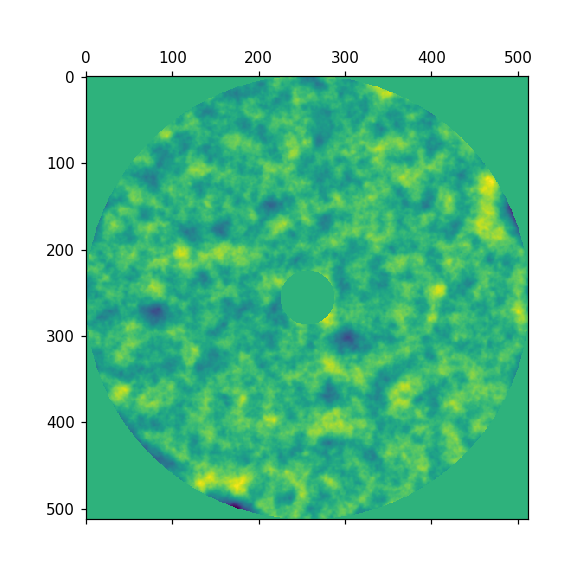

In [4]:
# Or, the COMPASS intended way:
sup.reset()
sup.loop(1000)
x = sup.target.get_tar_phase(0,pupil=True)
x[x!=0]-=x[x!=0].mean()
plt.matshow(x)

## Phase-Based Control Matrix
A.k.a., geometric controller. The idea is to take the atmospheric phase at the wave-front sensor, $\varphi_\mathrm{atmos}$, and find the DM command, $u$, that would cause the opposite phase on the DM, $\varphi_\mathrm{dm} = -\varphi_\mathrm{atmos}$. Of course, there are only so many actuators in a DM, so one cannot expect to exactly cancel the atmospheric phase with the DM phase. One practical compromise is to minimise the difference between the two, in a *least-squares* sense.

### Phase Interaction Matrix
In the same way as for the *slope-minimising* controller, we can build a *phase-minimising* controller using the interaction matrix, $D_\varphi$, between the DM command, $u$, and the WFS phase, $\varphi$, directly.

In [5]:
nact_ol = sup.dms.get_influ_function(1).shape[2]
print(nact_ol)
u_onehot = np.zeros(nact_ol)
u_onehot[0] = 1.0
Dphi = []
sup.rtc.set_command(0,np.zeros(nact))
sup.rtc.apply_control(0,comp_voltage=False)
for i in range(nact_ol):
    u_tmp = np.roll(u_onehot,i)
    # apply one-hot command vector
    sup.dms.set_command(u_tmp,dm_index=1)
    # only trace dms phase
    sup.wfs.raytrace(1,dms=sup.dms)
    phi_tmp = (sup.wfs.get_wfs_phase(1)[pup_filter]).flatten()
    Dphi.append(phi_tmp)
Dphi = np.c_[Dphi].T
print(f"{Dphi.shape=}")
print(Dphi.max())

784
Dphi.shape=(203580, 784)
0.009999982


In [6]:
# we'll need the closed loop DM dphi and cphi too now
nact_cl = sup.dms.get_influ_function(0).shape[2]+2
print(nact_cl)
u_onehot = np.zeros(nact_cl)
u_onehot[0] = 1.0
Dphi_cl = []
sup.rtc.set_command(0,np.zeros(nact))
sup.rtc.set_command(1,np.zeros(nact_ol))
sup.rtc.apply_control(0,comp_voltage=False)
sup.rtc.apply_control(1,comp_voltage=False)
for i in range(nact_cl):
    u_tmp = np.roll(u_onehot,i)
    # apply one-hot command vector
    sup.dms.set_command(u_tmp[:-2],dm_index=0)
    sup.dms.set_command(u_tmp[-2:],dm_index=2)
    # only trace dms phase
    sup.wfs.raytrace(0,dms=sup.dms)
    phi_tmp = (sup.wfs.get_wfs_phase(0)[pup_filter]).flatten()
    Dphi_cl.append(phi_tmp)
Dphi_cl = np.c_[Dphi_cl].T
print(f"{Dphi_cl.shape=}")
print(Dphi_cl.max())

222
Dphi_cl.shape=(203580, 222)
0.01


<IPython.core.display.Javascript object>


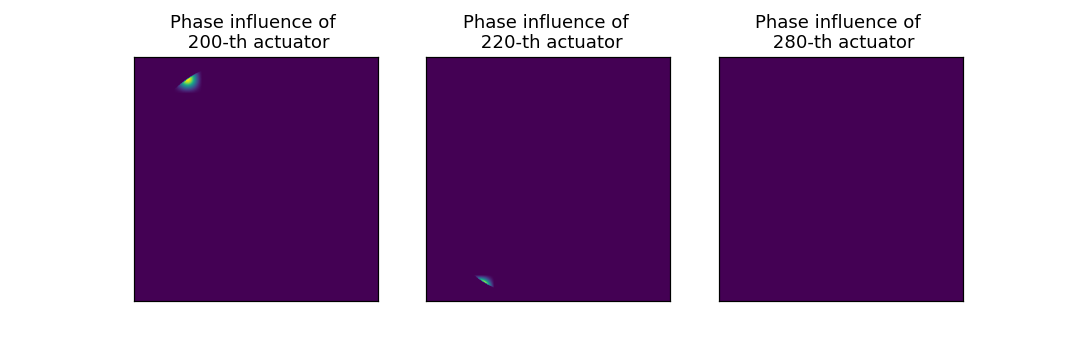

In [7]:
fig,ax = plt.subplots(1,3,figsize=[9,3])
tmp = pup.copy()

j=0
i=200; tmp[pup_filter] = Dphi[:,i]; ax[j].imshow(tmp);ax[j].set_xticks([]);ax[j].set_yticks([])
ax[j].set_title(f"Phase influence of \n {i:d}-th actuator"); j+=1;
i=220; tmp[pup_filter] = Dphi[:,i]; ax[j].imshow(tmp);ax[j].set_xticks([]);ax[j].set_yticks([])
ax[j].set_title(f"Phase influence of \n {i:d}-th actuator"); j+=1;
i=280; tmp[pup_filter] = Dphi[:,i]; ax[j].imshow(tmp);ax[j].set_xticks([]);ax[j].set_yticks([])
ax[j].set_title(f"Phase influence of \n {i:d}-th actuator"); j+=1;


### Phase Command Matrix

Though we can't directly access the phase in practice, we can in simulation. This is useful to test the absolute upper limit of AO performance, or if we have a way to estimate the phase directly (e.g., Kalman Filter, GAN, etc).

\begin{aligned}
J(u) & = || \varphi_\mathrm{residual}||^2 \\
& = || \varphi_\mathrm{atm} + \varphi_\mathrm{dm} ||^2 \\
& = ||\varphi_\mathrm{atm} + D_\varphi u||^2 \\
& = (\varphi_\mathrm{atm} + D_\varphi u)^T(\varphi_\mathrm{atm} + D_\varphi u) \\
& = \varphi_\mathrm{atm}^T\varphi_\mathrm{atm} + 2\varphi^TD_\varphi^T\varphi_\mathrm{atm} + u^TD_\varphi^T D_\varphi u \\
& = 2u^TD_\varphi^T\varphi_\mathrm{atm} + u^TD_\varphi^T D_\varphi u
\end{aligned}

Which has a unique global minimum when $\nabla J = \frac{\partial J}{\partial u} = \vec{0}$ 
$$
\nabla J(u) = 2D_\varphi^T\varphi_\mathrm{atm} + 2D_\varphi^T D_\varphi u = \vec{0}
$$
$$
\therefore u = -\underbrace{(D_\varphi^T D_\varphi)^{-1}D_\varphi^T}_{\triangleq C_\varphi}\varphi_\mathrm{atm}
$$
where $C$ is the *control matrix*. This means, that given a slope vector based on the atmosphere, we can find a command vector that will minimise the total WFS slopes by:
$$
u = -C_\varphi \varphi_\mathrm{atm}
$$

In [8]:
print(f"{np.linalg.cond(Dphi.T @ Dphi+ 1e-6*np.eye(Dphi.shape[1]))=}")
cphi = np.linalg.solve(Dphi.T @ Dphi + 1e-6*np.eye(Dphi.shape[1]), Dphi.T)
print(f"{cphi.shape=}")

np.linalg.cond(Dphi.T @ Dphi+ 1e-6*np.eye(Dphi.shape[1]))=187986.23472660762
cphi.shape=(784, 203580)


In [9]:
# this is needed to "decouple" the GAN and closed-loop controller slopes, 
# so more truly "woofer-tweeter" type control.
print(f"{np.linalg.cond(Dphi_cl.T @ Dphi_cl+ 1e-6*np.eye(Dphi_cl.shape[1]))=}")
cphi_cl = np.linalg.solve(Dphi_cl.T @ Dphi_cl + 1e-6*np.eye(Dphi_cl.shape[1]), Dphi_cl.T)
print(f"{cphi_cl.shape=}")
gan_cl_filter = cphi @ Dphi_cl @ cmat

np.linalg.cond(Dphi_cl.T @ Dphi_cl+ 1e-6*np.eye(Dphi_cl.shape[1]))=10717.92214223646
cphi_cl.shape=(222, 203580)


<IPython.core.display.Javascript object>


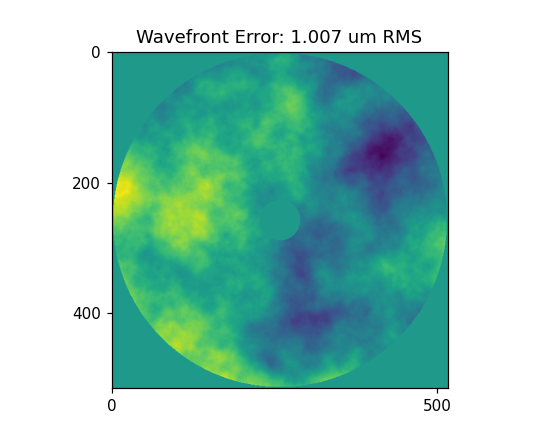

<IPython.core.display.Javascript object>


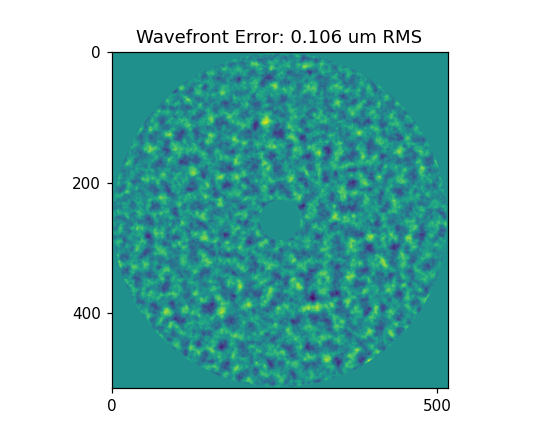

Text(0.5, 1.0, 'Wavefront Error: 0.106 um RMS')

In [10]:
sup.reset()

# compute the WFS phase using only the atmospheric phase
sup.wfs.raytrace(1,atm=sup.atmos)

plt.figure(figsize=[5,4])
phi = pfphase(sup.wfs.get_wfs_phase(1))
plt.imshow(phi)
plt.title(f"Wavefront Error: {(phi[pup_filter]**2).mean()**0.5:0.3f} um RMS")

# compute open-loop command to minimise slopes
u = -cphi @ phi[pup_filter]

# perform correction
sup.dms.set_command(u,dm_index=1)
sup.wfs.raytrace(1,dms=sup.dms,atm=sup.atmos)

plt.figure(figsize=[5,4])
phi = pfphase(sup.wfs.get_wfs_phase(1))
plt.imshow(phi)
plt.title(f"Wavefront Error: {(phi[pup_filter]**2).mean()**0.5:0.3f} um RMS")

DM0: 100%|█████████████████████████████████| 784/784 [00:00<00:00, 11280.81it/s]

Doing imat geom...


<IPython.core.display.Javascript object>


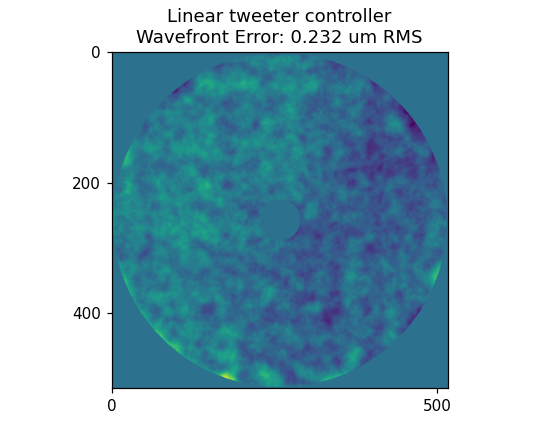

Text(0.5, 1.0, 'Linear tweeter controller\nWavefront Error: 0.232 um RMS')

In [11]:
# build a linear reconstructor for tweeter DM (since reviewer wanted it)
from shesha.ao import imats
imat_dmnew = imats.imat_geom(wfs=sup.wfs._wfs, dms=sup.dms._dms,
            p_wfss=sup.config.p_wfss, p_dms=sup.config.p_dms,
            p_controller=sup.config.p_controllers[1], meth=0)

cmat_dmnew = np.linalg.solve(imat_dmnew.T @ imat_dmnew + 1e-7*np.eye(imat_dmnew.shape[1]),imat_dmnew.T)
#the effective cmat should not reconstruct the part that
# will be sent to the closed-loop DM, so we need to remove that:
# note that this assumes the same gain and delay will be applied to each loop
cmat_dmnew_effective = cmat_dmnew - cmat_dmnew @ imat @ cmat

sup.reset()

# compute the WFS phase using only the atmospheric phase
sup.wfs.raytrace(1,atm=sup.atmos)
# compute open-loop command to minimise slopes
sup.wfs.compute_wfs_image(1)
sup.rtc.do_centroids(1)
s = sup.rtc.get_slopes(1)
u = -cmat_dmnew @ s

# perform correction
sup.dms.set_command(u,dm_index=1)
sup.wfs.raytrace(1,dms=sup.dms,atm=sup.atmos)

plt.figure(figsize=[5,4])
phi = pfphase(sup.wfs.get_wfs_phase(1))
plt.imshow(phi)
plt.title(f"Linear tweeter controller\nWavefront Error: {(phi[pup_filter]**2).mean()**0.5:0.3f} um RMS")

# Test the Inference from model from previous experiments

This demonstrates the known working experimental data.


----------------------------------------------------
iter# | S.E. SR | L.E. SR | ETR (s) | Framerate (Hz)
----------------------------------------------------
22900 	 0.624 	  0.563	     -15.2 	 1496.6
23000 	 0.652 	  0.607	     -30.1 	 756.2
 loop execution time: 0.2695577144622803   ( 200 iterations),  0.0013477885723114013 (mean)   741.9561350672692 Hz


<IPython.core.display.Javascript object>


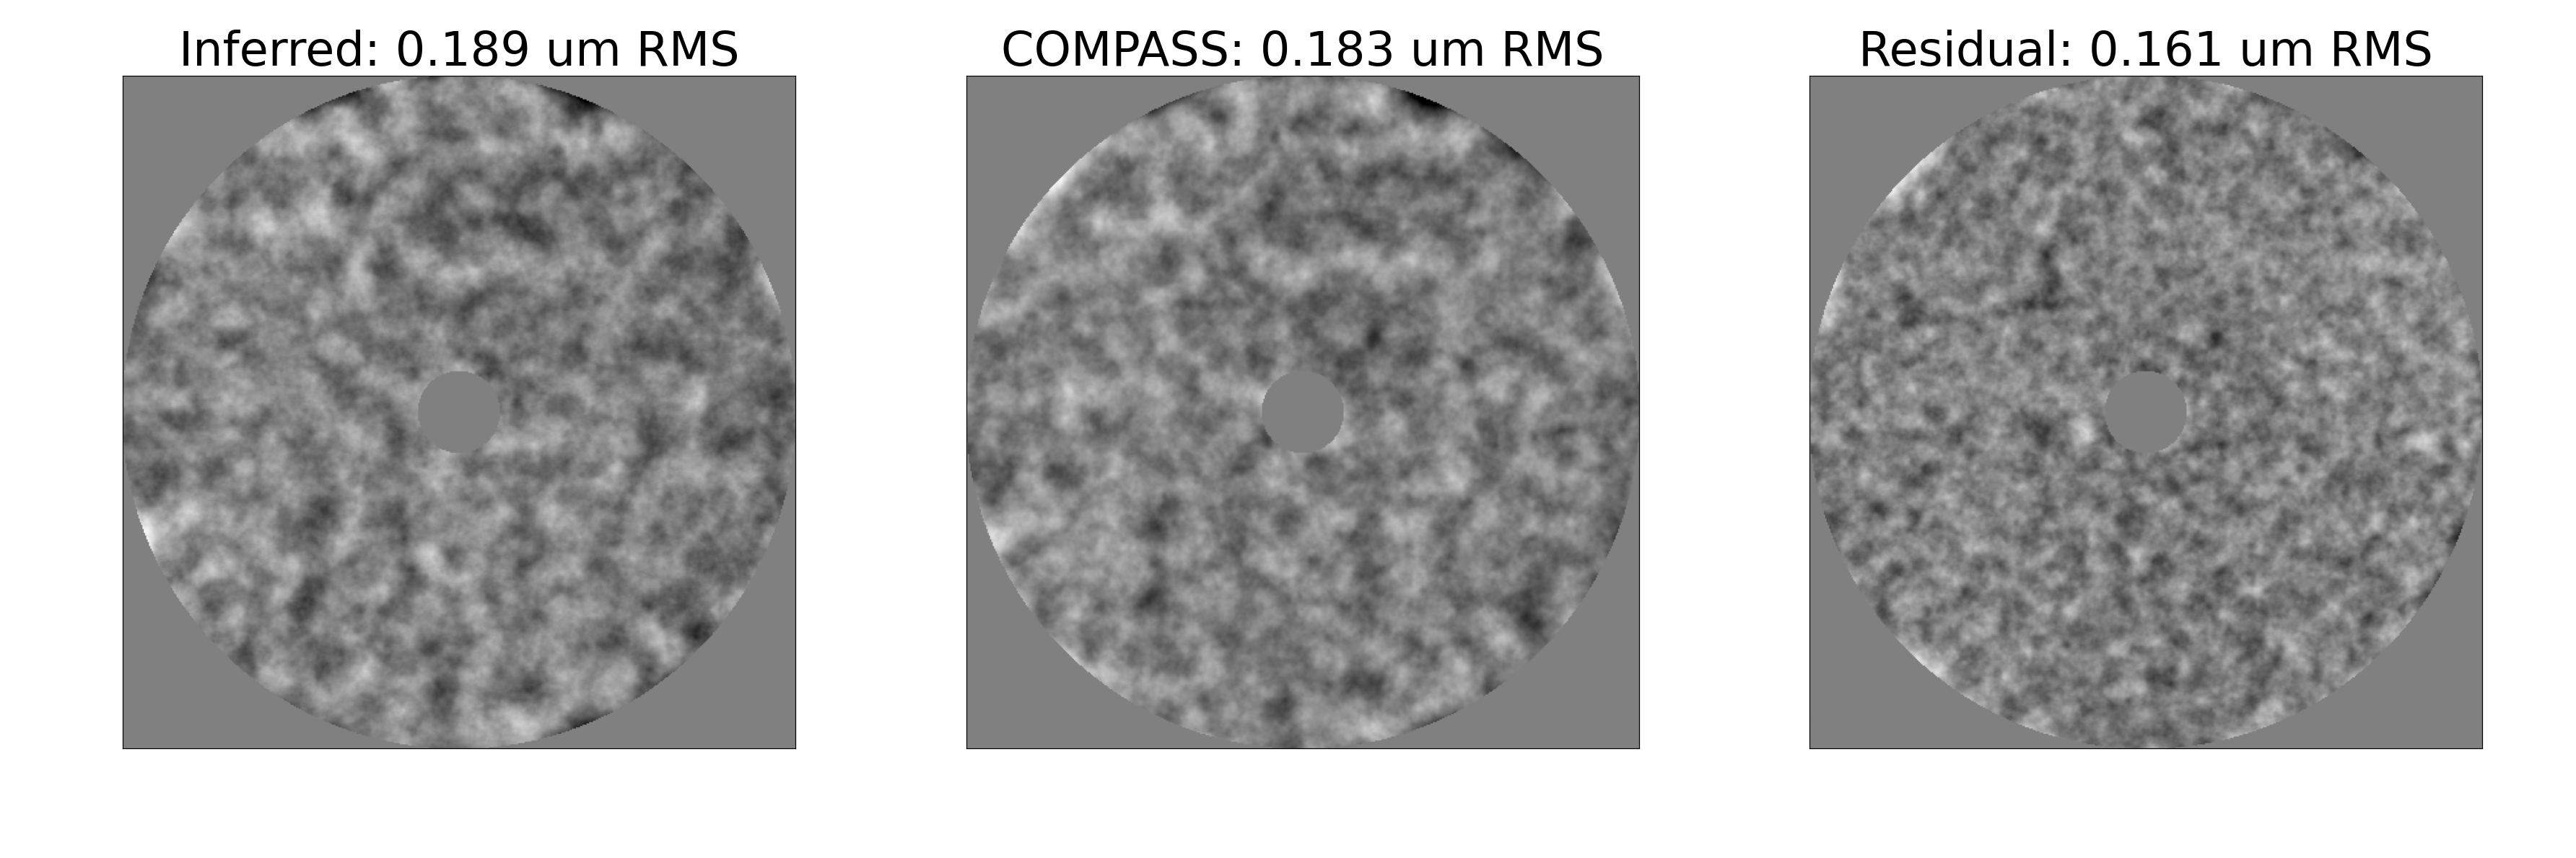

In [61]:
def im_to_phase(wfs_image):
    theAIdata = SetData(wfs_image)
    model.set_input(theAIdata)
    model.test()
    visuals = model.get_current_visuals()
    inferred_phase = visuals['fake_B']
    inferred_phase = inferred_phase.cpu()
    inferred_phase = inferred_phase.detach().numpy()
    inferred_phase = numpy.squeeze(inferred_phase)
    inferred_phase = DeGANPhase(inferred_phase)
    return inferred_phase

#sup.atmos.set_r0(0.08)
sup.reset()
#sup.atmos.set_wind([5.0])
sup.loop(200)
fig,ax = plt.subplots(1,3,figsize=[30,10])
plt.rc('font', size=36)
phi = pfphase(sup.wfs.get_wfs_phase(0))[2:-2,2:-2]
inferred_phase = (im_to_phase(sup.wfs.get_wfs_image(0)))
inferred_phase[sup.get_s_pupil()==1]-=inferred_phase[sup.get_s_pupil()==1].mean()
plt.tight_layout()
ax[0].imshow(inferred_phase)
ax[0].set_title(f"Inferred: {inferred_phase[sup.get_s_pupil()==1].std():0.3f} um RMS")
ax[1].imshow(phi)
ax[1].set_title(f"COMPASS: {phi[sup.get_s_pupil()==1].std():0.3f} um RMS")
ax[2].imshow(phi-inferred_phase)
ax[2].set_title(f"Residual: {((inferred_phase-phi)[sup.get_s_pupil()==1]).std():0.3f} um RMS")
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[0].images[0].set_clim(-1, 1)
ax[1].images[0].set_clim(-1, 1)
ax[2].images[0].set_clim(-1, 1)
plt.savefig("InferenceTest.png", transparent=True)

 ## Closed loop example with phase based control from phase estimation

In [13]:
mode = "olc"

sample_iter = np.arange(200,2000,200) # iteration numbers to sample wavefronts
true_cl_phase  = []
gan_cl_phase   = []
slope_cl_phase = []
wfs_image = []

##Winner so far = H.I. g.83 l.0001
                #H.P. gp.0.60 g2.60 (try more)

# try tuning these:
gain_polc = 0.4
#0.40
u    = np.zeros(nact_ol)
sup.reset()

sup.rtc.set_command(0,np.zeros(nact))
sup.rtc.set_command(1,np.zeros(nact_ol))
sup.rtc.set_iir_a_vector(1,0,np.zeros(nact_ol))
sup.rtc.set_iir_b_vector(1,0,np.zeros(nact_ol))

print("Purely Linear")
sup.loop(2000)
x = sup.target.get_tar_phase(0,pupil=True)
x[x!=0] -= x[x!=0].mean()
print(f"  LE off: {sup.target.get_strehl(0)[1]*100:5.2f}%, {x[x!=0].std()*1e3:0.1f} nm RMS\n\n")
n_iter = 2100
sup.reset()
print("GAN Assisted")
print("""--------------------------
iter# | S.E. SR | L.E. SR
--------------------------""")

for i in range(n_iter):
    sup.next(apply_control=False)
    if (i%100==0):
        x = sup.target.get_tar_phase(0,pupil=True)
        x[x!=0] -= x[x!=0].mean()
        print(f"{i:5d}    {sup.target.get_strehl(0)[0]:5.3f}    {sup.target.get_strehl(0)[1]:5.3f}")
    
    s = sup.rtc.get_slopes(0)

    if i > 100:
        # retrieve closed-loop phase from GAN
        phase = im_to_phase(sup.wfs.get_wfs_image(0))            
        # compute open loop commands
        du = cphi @ phase[pup_filter[2:-2,2:-2]] - 0.7 * gan_cl_filter @ s
        u  = (1-gain_polc)*u - gain_polc * du #polc 
    
    if i in sample_iter:
        # wfs phase (causing now's wfs image)
        x = (sup.wfs.get_wfs_phase(0)*sup.get_m_pupil())[2:-2,2:-2]
        x[x!=0]-=x[x!=0].mean()
        true_cl_phase.append(x)
        x = (sup.wfs.get_wfs_image(0))
        wfs_image.append(x)
        # gan phase (estimated from now's wfs image)
        x = phase*sup.get_s_pupil()
        x[x!=0]-=x[x!=0].mean()
        gan_cl_phase.append(x)
        # slope phase (estimated from now's wfs image)
        u_nogan = cmat_dmnew @ s
        sup.dms.set_command(u_nogan,dm_index=1)
        sup.dms.set_command(np.zeros(dm_old.get_ntotact()),dm_index=0)
        sup.dms.set_command(np.zeros(2),dm_index=2)
        sup.wfs.raytrace(1,dms=sup.dms)
        x = (sup.wfs.get_wfs_phase(1)*sup.get_m_pupil())[2:-2,2:-2]
        x[x!=0]-=x[x!=0].mean()
        slope_cl_phase.append(x)
    
    u -= u.mean()
    sup.rtc.set_command(1,u)
    sup.rtc.apply_control(0)
    sup.rtc.apply_control(1)    

x = sup.target.get_tar_phase(0,pupil=True)
x[x!=0] -= x[x!=0].mean()
print(f"  LE  on: {sup.target.get_strehl(0)[1]*100:5.2f}%, {x[x!=0].std()*1e3:0.1f} nm RMS")

Purely Linear
----------------------------------------------------
iter# | S.E. SR | L.E. SR | ETR (s) | Framerate (Hz)
----------------------------------------------------
3200 	 0.636 	  0.603	     -1.6 	 761.3
3300 	 0.628 	  0.616	     -1.7 	 766.8
3400 	 0.619 	  0.615	     -1.9 	 755.2
3500 	 0.658 	  0.615	     -2.0 	 767.0
3600 	 0.609 	  0.616	     -2.1 	 760.8
3700 	 0.644 	  0.616	     -2.2 	 759.8
3800 	 0.616 	  0.615	     -2.4 	 761.1
3900 	 0.621 	  0.616	     -2.5 	 761.7
4000 	 0.634 	  0.617	     -2.6 	 759.9
4100 	 0.654 	  0.619	     -2.8 	 762.6
4200 	 0.639 	  0.621	     -2.9 	 762.4
4300 	 0.652 	  0.622	     -3.0 	 765.8
4400 	 0.625 	  0.623	     -3.1 	 762.0
4500 	 0.637 	  0.623	     -3.3 	 764.7
4600 	 0.626 	  0.624	     -3.4 	 761.3
4700 	 0.621 	  0.623	     -3.5 	 765.2
4800 	 0.641 	  0.623	     -3.7 	 763.9
4900 	 0.619 	  0.624	     -3.8 	 763.6
5000 	 0.609 	  0.623	     -3.9 	 761.9
5100 	 0.615 	  0.622	     -4.0 	 766.8
 loop execution time: 2.626

In [14]:
# try tuning these:
gain_polc = 0.4
#0.40
u    = np.zeros(nact_ol)
sup.reset()

sup.rtc.set_command(0,np.zeros(nact))
sup.rtc.set_command(1,np.zeros(nact_ol))
sup.rtc.set_iir_a_vector(1,0,np.zeros(nact_ol))
sup.rtc.set_iir_b_vector(1,0,np.zeros(nact_ol))

# clean up with linear controller
for i in range(2000):
    sup.next()

# run linear open loop tweeter
n_iter = 2100
sup.reset()
print("Linear open-loop tweeter")
print("""--------------------------
iter# | S.E. SR | L.E. SR
--------------------------""")

for i in range(n_iter):
    sup.next(apply_control=False)
    if (i%100==0):
        x = sup.target.get_tar_phase(0,pupil=True)
        x[x!=0] -= x[x!=0].mean()
        print(f"{i:5d}    {sup.target.get_strehl(0)[0]:5.3f}    {sup.target.get_strehl(0)[1]:5.3f}")
    
    s = sup.rtc.get_slopes(0)

    if i > 100:
        du = cmat_dmnew_effective @ s
        u  = (1-gain_polc)*u - gain_polc * du #polc 
        
    u -= u.mean()
    sup.rtc.set_command(1,u)
    sup.rtc.apply_control(0)
    sup.rtc.apply_control(1)    

x = sup.target.get_tar_phase(0,pupil=True)
x[x!=0] -= x[x!=0].mean()
print(f"  LE  on: {sup.target.get_strehl(0)[1]*100:5.2f}%, {x[x!=0].std()*1e3:0.1f} nm RMS")

Linear open-loop tweeter
--------------------------
iter# | S.E. SR | L.E. SR
--------------------------
    0    0.025    0.025
  100    0.637    0.588
  200    0.661    0.633
  300    0.664    0.643
  400    0.679    0.648
  500    0.656    0.650
  600    0.673    0.652
  700    0.661    0.653
  800    0.677    0.655
  900    0.687    0.658
 1000    0.704    0.660
 1100    0.691    0.662
 1200    0.702    0.664
 1300    0.658    0.665
 1400    0.656    0.665
 1500    0.675    0.665
 1600    0.671    0.666
 1700    0.689    0.667
 1800    0.651    0.668
 1900    0.654    0.668
 2000    0.695    0.668
  LE  on: 66.77%, 165.4 nm RMS


In [15]:
sup.rtc.set_command(0,np.zeros(nact))
sup.rtc.set_command(1,np.zeros(nact_ol))
sup.rtc.set_iir_a_vector(1,0,np.zeros(nact_ol))
sup.rtc.set_iir_b_vector(1,0,np.zeros(nact_ol))

n_iter = 2100
sup.reset()
print("Geometric")
print("""--------------------------
iter# | S.E. SR | L.E. SR
--------------------------""")


for i in range(n_iter):
    sup.next(apply_control=False)
    u = - cphi @ sup.wfs.get_wfs_phase(0)[pup_filter]        
    if (i%100==0):
        x = sup.target.get_tar_phase(0,pupil=True)
        x[x!=0] -= x[x!=0].mean()
        print(f"{i:5d}    {sup.target.get_strehl(0)[0]:5.3f}    {sup.target.get_strehl(0)[1]:5.3f}")
    u -= u.mean()
    sup.rtc._rtc.d_control[1].d_com.host2device(u)
    sup.rtc.apply_control(1,comp_voltage=True)

x = sup.target.get_tar_phase(0,pupil=True)
x[x!=0] -= x[x!=0].mean()
print(f"  LE  on: {sup.target.get_strehl(0)[1]*100:5.2f}%, {x[x!=0].std()*1e3:0.1f} nm RMS")

Geometric
--------------------------
iter# | S.E. SR | L.E. SR
--------------------------
    0    0.025    0.025
  100    0.841    0.827
  200    0.836    0.835
  300    0.842    0.837
  400    0.845    0.838
  500    0.840    0.839
  600    0.836    0.839
  700    0.839    0.839
  800    0.844    0.839
  900    0.846    0.839
 1000    0.844    0.840
 1100    0.842    0.840
 1200    0.847    0.840
 1300    0.839    0.841
 1400    0.836    0.841
 1500    0.839    0.841
 1600    0.843    0.840
 1700    0.841    0.841
 1800    0.836    0.841
 1900    0.837    0.840
 2000    0.841    0.840
  LE  on: 83.99%, 109.8 nm RMS


1


<IPython.core.display.Javascript object>


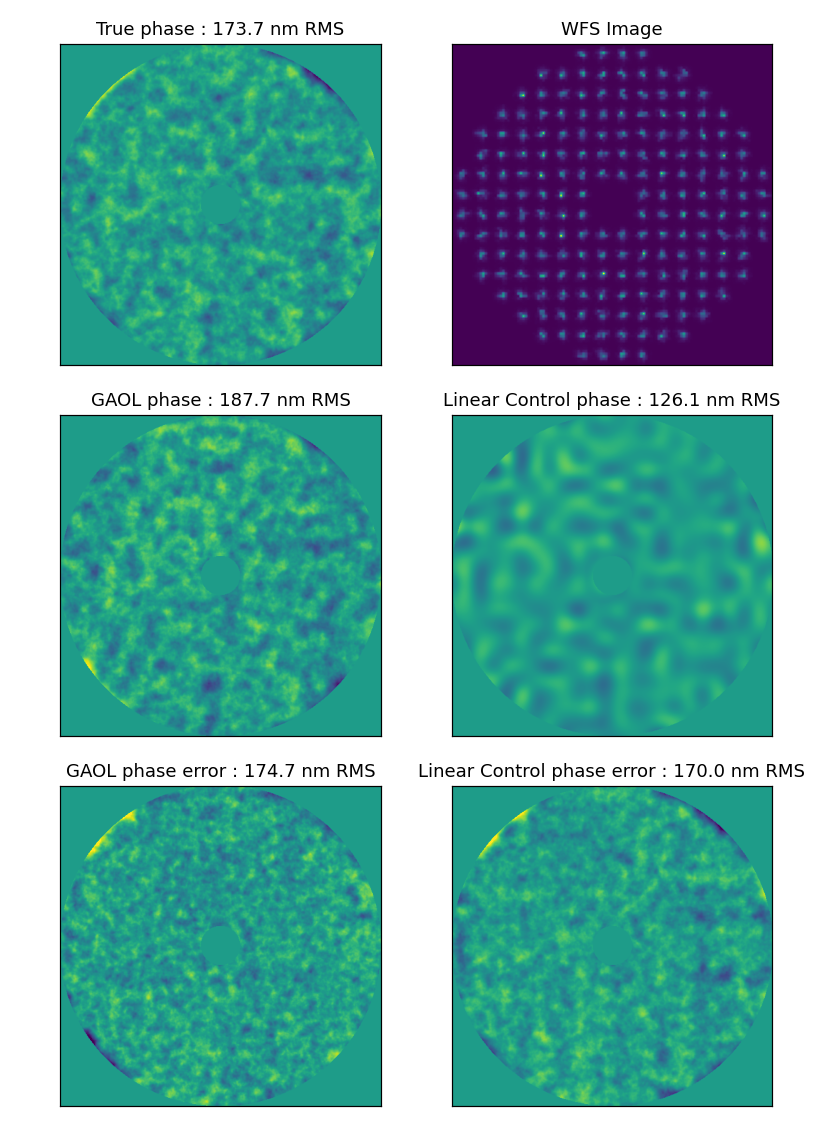

2


<IPython.core.display.Javascript object>


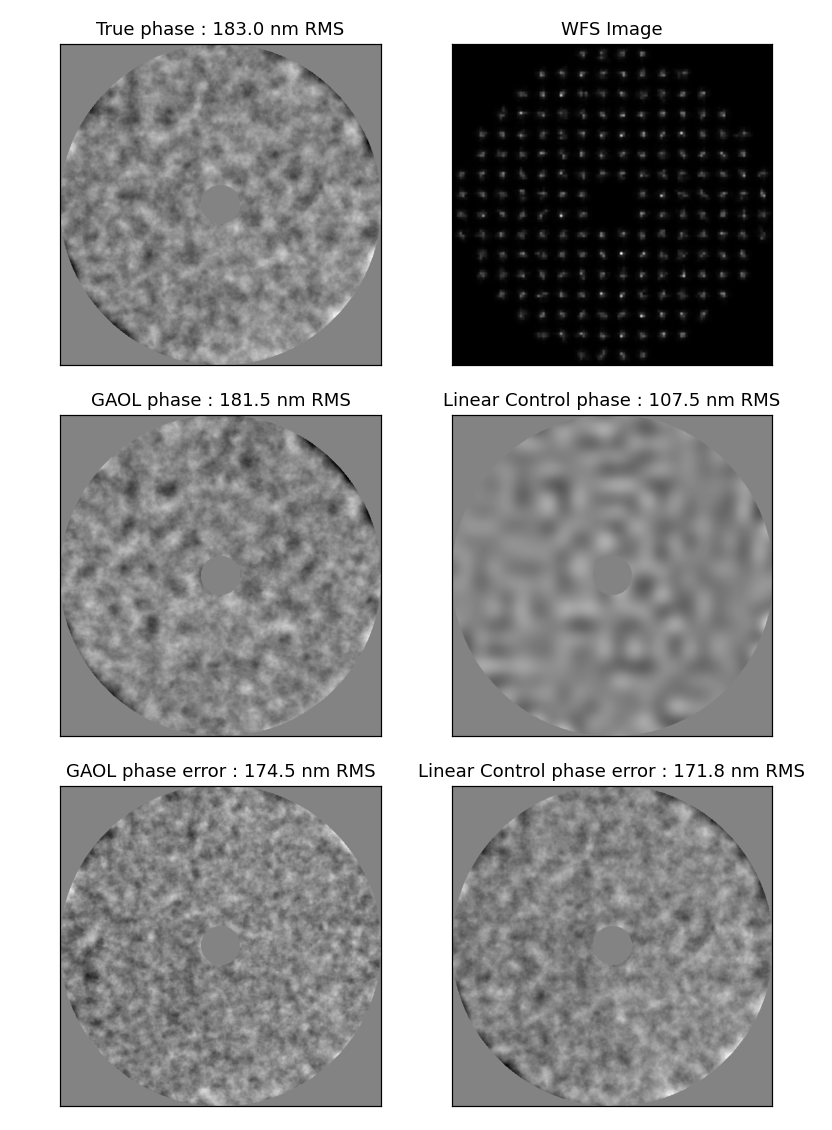

3


<IPython.core.display.Javascript object>


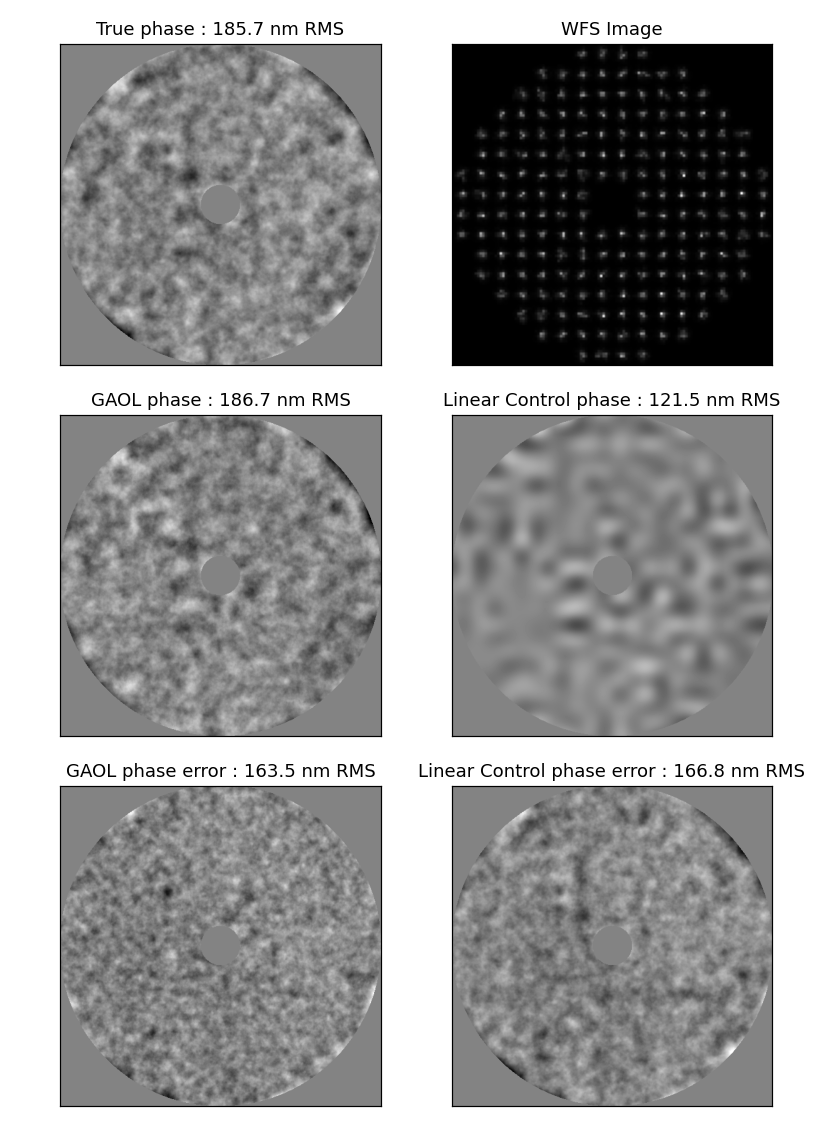

4


<IPython.core.display.Javascript object>


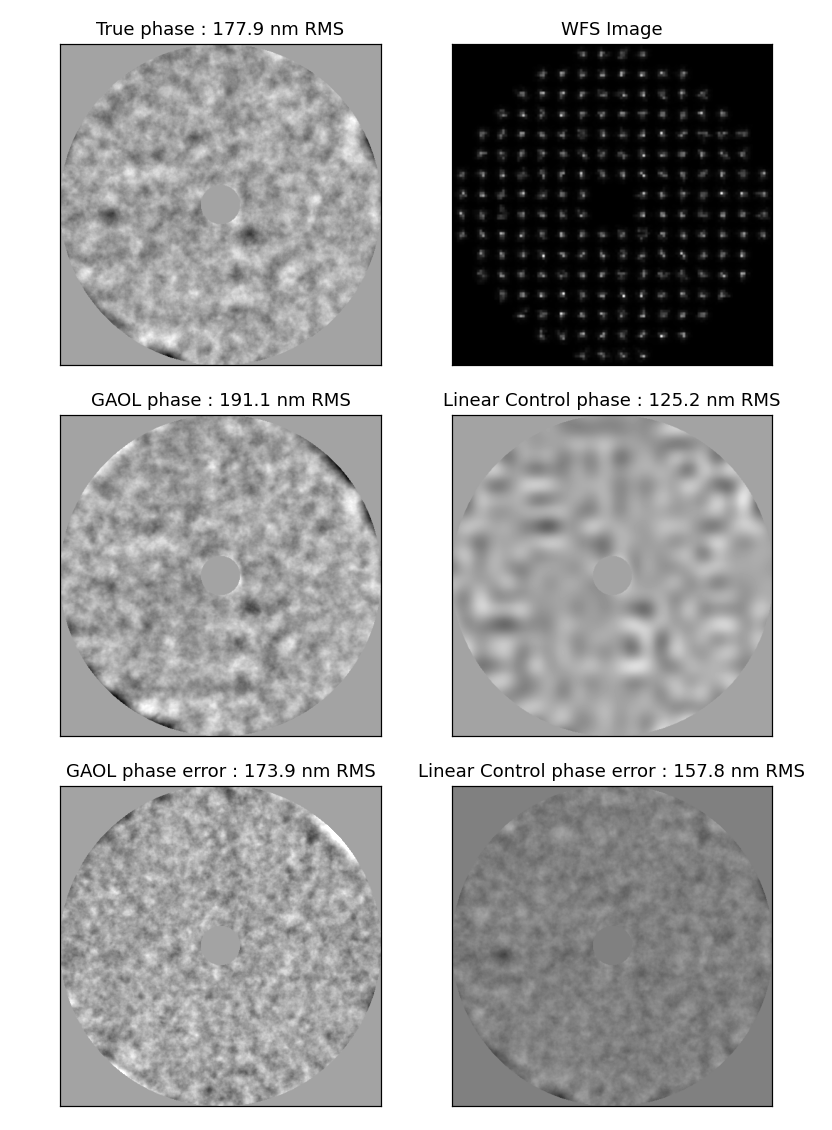

In [16]:
true_cl_phase  = np.r_[true_cl_phase ]
gan_cl_phase   = np.r_[gan_cl_phase  ]
slope_cl_phase = np.r_[slope_cl_phase]
wfs_image      = np.r_[wfs_image     ]

for which_sample in np.arange(1,5):
    print(which_sample)
    #fig,ax = plt.subplots(3,2,figsize=[35,47.5])
    #plt.rc('font', size=40)
    fig,ax = plt.subplots(3,2,figsize=[7,9.5])
    ax[0,0].imshow(true_cl_phase [which_sample,:,:])
    ax[0,0].set_title(f"True phase : {true_cl_phase[which_sample,:,:][pup_filter[2:-2,2:-2]].std()*1000:0.1f} nm RMS")
    ax[1,0].imshow(gan_cl_phase  [which_sample,:,:])
    ax[1,0].set_title(f"GAOL phase : {gan_cl_phase[which_sample,:,:][pup_filter[2:-2,2:-2]].std()*1000:0.1f} nm RMS")
    ax[1,1].imshow(slope_cl_phase[which_sample,:,:])
    ax[1,1].set_title(f"Linear Control phase : {slope_cl_phase[which_sample,:,:][pup_filter[2:-2,2:-2]].std()*1000:0.1f} nm RMS")
    ax[0,1].imshow(wfs_image[which_sample,:,:])
    ax[0,1].set_title(f"WFS Image")
    ax[2,0].imshow((true_cl_phase-gan_cl_phase)[which_sample,:,:])
    ax[2,0].set_title(f"GAOL phase error : {(true_cl_phase-gan_cl_phase)[which_sample,:,:][pup_filter[2:-2,2:-2]].std()*1000:0.1f} nm RMS")
    ax[2,1].imshow((true_cl_phase-slope_cl_phase)[which_sample,:,:])
    ax[2,1].set_title(f"Linear Control phase error : {(true_cl_phase-slope_cl_phase)[which_sample,:,:][pup_filter[2:-2,2:-2]].std()*1000:0.1f} nm RMS")
    for axi in ax.flatten():
        if len(axi.images)>0:
            axi.images[0].set_clim([true_cl_phase[which_sample,:,:].min(),true_cl_phase[which_sample,:,:].max()])
    ax[0,1].images[0].set_clim([wfs_image[which_sample,:,:].min(),wfs_image[which_sample,:,:].max()])
    #([wfs_image[which_sample,:,:].min(),wfs_image[which_sample,:,:].max()])
    #print(ax.flatten())
    ax[0,0].get_xaxis().set_visible(False)
    ax[0,0].get_yaxis().set_visible(False)
    ax[0,1].get_xaxis().set_visible(False)
    ax[0,1].get_yaxis().set_visible(False)
    ax[1,0].get_xaxis().set_visible(False)
    ax[1,0].get_yaxis().set_visible(False)
    ax[1,1].get_xaxis().set_visible(False)
    ax[1,1].get_yaxis().set_visible(False)
    ax[2,0].get_xaxis().set_visible(False)
    ax[2,0].get_yaxis().set_visible(False)
    ax[2,1].get_xaxis().set_visible(False)
    ax[2,1].get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.gray()
    plt.savefig(str(which_sample)+".png", transparent=True)

In [17]:
# Calculate Max / Min for each image (required for paper)

n=5
for n in np.arange(1,5):
    print(n)
    print(np.max(true_cl_phase [n,:,:]))
    print(np.min(true_cl_phase [n,:,:]))
    print()
    print(np.max(gan_cl_phase [n,:,:]))
    print(np.min(gan_cl_phase [n,:,:]))
    print()
    print(np.max(slope_cl_phase [n,:,:]))
    print(np.min(slope_cl_phase [n,:,:]))
    print()
    print(np.max(true_cl_phase [n,:,:] - gan_cl_phase [1,:,:]))
    print(np.min(true_cl_phase [n,:,:] - gan_cl_phase [1,:,:]))
    print()
    print(np.max(true_cl_phase [n,:,:] - slope_cl_phase [1,:,:]))

    print(np.min(true_cl_phase [n,:,:] - slope_cl_phase [1,:,:]))

1
0.88059807
-1.0884085

0.95182264
-1.0213357

0.5386018
-0.47510046

1.2935535
-1.449855

1.2165005
-1.1524125
2
1.0659523
-1.1503677

0.9641634
-1.3533537

0.5695038
-0.41295737

2.0237753
-1.5098672

1.1628015
-1.1120571
3
0.9846134
-1.0509434

0.7736927
-1.2305417

0.50781894
-0.45372152

1.8575082
-1.5687333

1.1948913
-1.2279615
4
0.73202515
-1.31849

0.75640064
-1.3866774

0.500156
-0.52447623

1.0514784
-1.3792362

0.9035158
-1.1286749


In [18]:
# Calculate Max - Min for each image (required for paper)

n=5
for n in np.arange(1,5):
    print(n)
    print('true_phase')
    print(np.max(true_cl_phase [n,:,:])-np.min(true_cl_phase [n,:,:]))
    print('gan')
    print(np.max(gan_cl_phase [n,:,:])-np.min(gan_cl_phase [n,:,:]))
    print('linear')
    print(np.max(slope_cl_phase [n,:,:])-np.min(slope_cl_phase [n,:,:]))
    print('gan error')
    print(np.max((true_cl_phase [n,:,:] - gan_cl_phase [1,:,:]))-(np.min(true_cl_phase [n,:,:] - gan_cl_phase [1,:,:])))
    print('linear error')
    print(np.max((true_cl_phase [n,:,:] - slope_cl_phase [1,:,:]))-(np.min(true_cl_phase [n,:,:] - slope_cl_phase [1,:,:])))
    print()

1
true_phase
1.9690065
gan
1.9731584
linear
1.0137023
gan error
2.7434084
linear error
2.3689132

2
true_phase
2.21632
gan
2.3175173
linear
0.98246115
gan error
3.5336425
linear error
2.2748585

3
true_phase
2.0355568
gan
2.0042343
linear
0.96154046
gan error
3.4262414
linear error
2.422853

4
true_phase
2.0505152
gan
2.143078
linear
1.0246322
gan error
2.4307146
linear error
2.0321908

